In [13]:
# Data Handling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# SMOTE for balancing
from imblearn.over_sampling import SMOTE

# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
# Load your CSV (replace with actual path if needed)
df = pd.read_csv('../Data/Fraud_Subset_10%.csv')

# Separate features and target
X = df.drop('fraud', axis=1)
y = df['fraud']

# Split before applying SMOTE (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


In [21]:
# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [22]:
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)


Plotting Trainings vs. Validation Loss

In [23]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_smote,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8614 - loss: 0.3163 - val_accuracy: 0.9761 - val_loss: 0.1086
Epoch 2/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9486 - loss: 0.1310 - val_accuracy: 0.9840 - val_loss: 0.0778
Epoch 3/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9611 - loss: 0.1023 - val_accuracy: 0.9843 - val_loss: 0.0712
Epoch 4/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9675 - loss: 0.0863 - val_accuracy: 0.9887 - val_loss: 0.0539
Epoch 5/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9703 - loss: 0.0774 - val_accuracy: 0.9871 - val_loss: 0.0552
Epoch 6/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9725 - loss: 0.0730 - val_accuracy: 0.9804 - val_loss: 0.0702
Epoch 7/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9733 - loss: 0.0720 - val_accuracy: 0.9784 - val_loss: 0.0813
Epoch 8/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9724 - loss: 0.0725 - val_accuracy: 0.9865 - val_

In [26]:
# Predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

4670/4670 ━━━━━━━━━━━━━━━━━━━━ 3s 613us/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    142319
           1       0.85      0.98      0.91      7118

    accuracy                           0.99    149437
   macro avg       0.92      0.98      0.95    149437
weighted avg       0.99      0.99      0.99    149437

ROC-AUC Score: 0.9991139379135895


ExactExplainer explainer: 149438it [43:13, 57.41it/s]                             


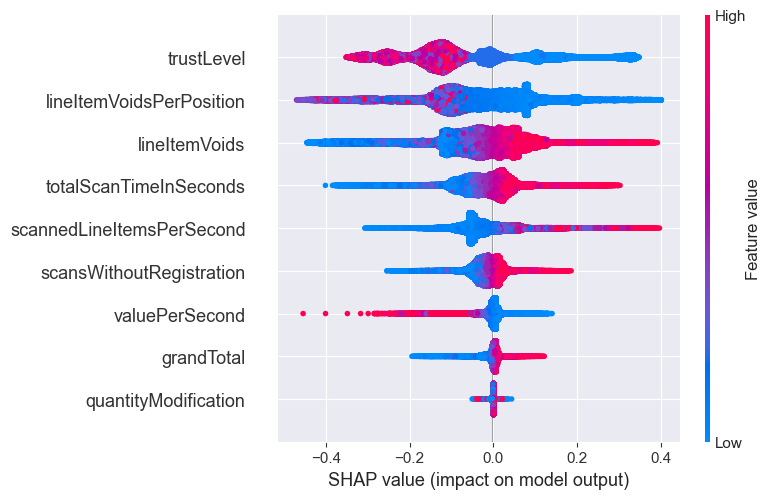

In [27]:
# SHAP Explanation
explainer = shap.Explainer(model, X_train_res)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [29]:
# Save Model
model.save("../Models/fraud_model.h5")

# Deploy as API
app = Flask(__name__)
loaded_model = tf.keras.models.load_model("../Models/fraud_model.h5")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    df = pd.DataFrame(data)
    df_scaled = scaler.transform(df)  # Apply same preprocessing
    prediction = (loaded_model.predict(df_scaled) > 0.5).astype(int)
    return jsonify({"fraud_prediction": prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


SystemExit: 1

C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [32]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("../Models/fraud_model.h5")


In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the full dataset
df_full = pd.read_csv("../Data/Fraud Original Full.csv")  

# Define features (drop target 'fraud' because we are predicting it)
X_full = df_full.drop(columns=["fraud"])  

# Apply the same scaling used in training
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)  # Normalize data


In [36]:
# Get fraud probabilities for the entire dataset
fraud_probabilities = model.predict(X_full_scaled)

# Convert probabilities to binary fraud predictions (0 = No Fraud, 1 = Fraud)
fraud_predictions = (fraud_probabilities > 0.5).astype(int)

# Add predictions to the original dataset
df_full["fraud_predicted"] = fraud_predictions

# Save results to a new CSV file
df_full.to_csv("Fraud_Predictions.csv", index=False)

print("Predictions saved to Fraud_Predictions.csv")


15567/15567 ━━━━━━━━━━━━━━━━━━━━ 9s 603us/step
Predictions saved to Fraud_Predictions.csv
